In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import collections
import seaborn as sns
from collections import defaultdict
import itertools


Load the data/get dimension etc 

In [2]:
data_leina=pd.DataFrame 
data_leina=pd.read_csv('w10-data.tbl', delim_whitespace=True)
g_names=data_leina.columns
infile = 'w10-data.tbl'
do_logspace_distance = False 
Q=8
data=np.log(data_leina.values)#simple fix # converts to log space 
N, G  = np.shape(data) 

visualise row data

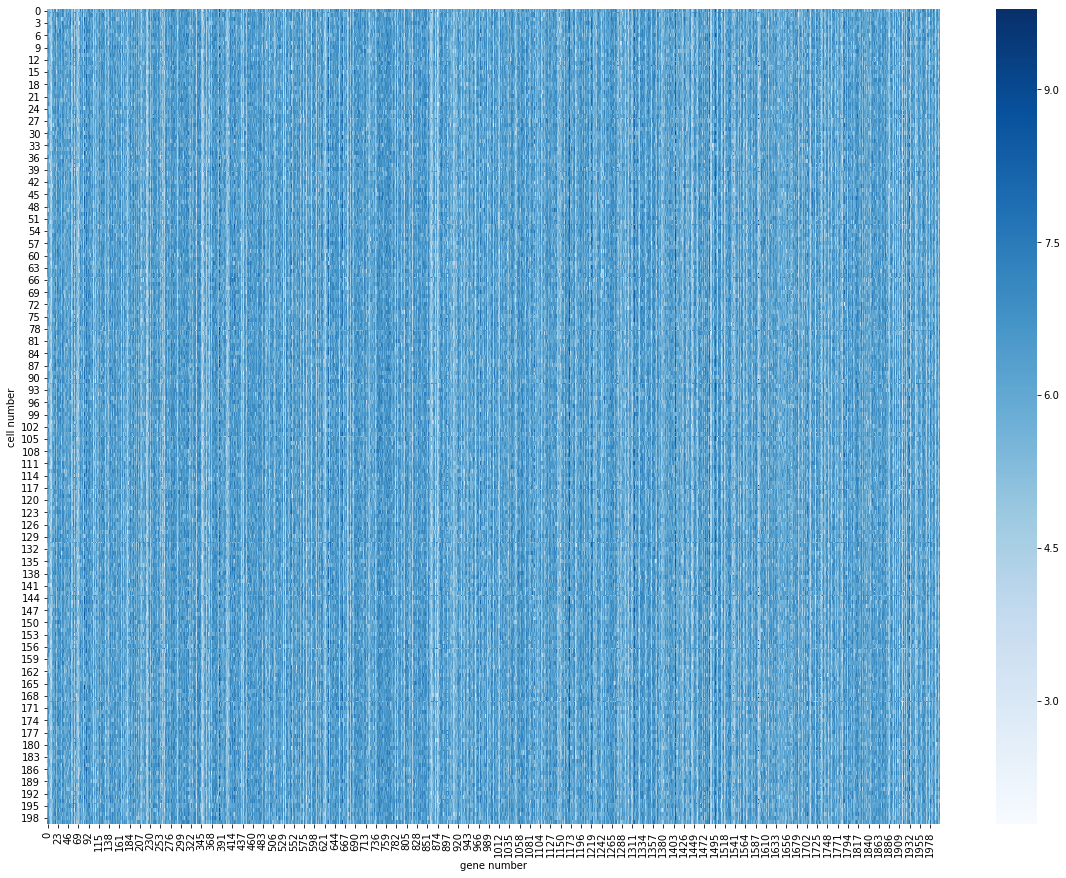

In [3]:
plt.subplots(figsize=(20,15))
sns.heatmap(data,cmap='Blues')
plt.xlabel("gene number")
plt.ylabel("cell number")
plt.show()

# PART 1
**Sean's answers** W5 

Modify the K-means clustering procedure you wrote for Wiggins’ data so that it works in 2001 dimensions, not
just 2. Run a reasonable number of iterations (20-100, or even better, test for convergence), starting from
several different initializations; report the lowest total squared distance (best clustering) you find for K=8. It
should be close to what Watson found using k = 8 clusters, where his clustering achieved a sum of the squared
distance = 87378.2. He used the “fixed” K-means method from part 3 of hw05, with his data represented as log
counts.

In [4]:
def euclidean_dist(v1, v2):
    """
    Return the euclidean distance || v1 - v2 ||.
    If do_logspace_distance is True, do || log(v1) - log(v2) || instead.
    """
    d = 0.
    for i in range(len(v1)):
        if do_logspace_distance:
            d += (np.log(float(v1[i])) - np.log(float(v2[i])))**2
        else:
            d += (v1[i] - v2[i])**2
    #print(d)        
    return np.sqrt(d)

In [5]:
def closest_centroid(x, centroids):
    """
    Input:
       centroids[k,g] : the current centroid positions, for centroids k=0..K-1, dimensions/genes g=0..G-1
       x[g]:            one data point
    Returns best_k, best_dist:
       best_k         : index of the best centroid (0..K-1)
       best_d         : distance to the best centroid
    """
    K, dim = np.shape(centroids)
    best_k = 0
    best_dist = euclidean_dist(x, centroids[0])
    for k in range(1,K):
        dist = euclidean_dist(x, centroids[k])
        if dist < best_dist:
            best_k    = k
            best_dist = dist
    return best_k, best_dist

In [6]:
def sample_component(X):
    """
    Returns a random centroid position
    Input: X[i,g] = the actual data; we use this to determine the min/max in each dimension,
                    and we sample a random vector uniformly on each dimension within those bounds.
    """
    X=X.astype(np.float) #convert elements to float instead of strings 
    N, G   = np.shape(X)
    dmax   = np.amax(X, axis=0)
    dmin   = np.amin(X, axis=0)
    mu     = np.zeros(G)
    for g in range(G):
        mu[g] = np.exp(np.random.uniform(np.log(dmin[g]), np.log(dmax[g])))
    return mu

In [7]:
def assign_kmeans(X, centroids):
    """
    Input:
       X[i,g] are the data point
       centroids[k] are the current centroid positions
    Return assignments, totdist:
       assignments[i] assign each data point i to a cluster k
       tot_sqdist is the total squared distance, the k-means objective function
    """
    K, dim      = np.shape(centroids)
    N           = len(X)
    assignments = np.zeros(N).astype(int)
    tot_sqdist  = 0
    for i,x in enumerate(X):
        assignments[i], di = closest_centroid(x, centroids)
        tot_sqdist += di**2
    return assignments, tot_sqdist

In [8]:
def update_kmeans(X, assignments, K):
    """
    Input:
      X[i,g] are the data points; i=0..N-1,  g=0..G-1
      assignments[i] : which centroid (0..K-1) each point has just been assigned to
      K : how many centroids there are
    Returns:
      centroids[k,g] : updated centroid positions
      pk[k]          : frequency of using component k: how many points were assigned to it, normalized.
    """
    N, G    = np.shape(X)              
    
    centroids = np.zeros((K,G))        
    counts    = np.zeros(K)
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            centroids[assignments[i], g] += X[i][g]

    for k in range(K):
        if counts[k] > 0:                                      # In a K-means implementation we have to watch out for the case
            centroids[k] = np.divide(centroids[k], counts[k])  # where a centroid gets no assigned points. Avoid dividing by zero.
        else:                                                  # One strategy is to leave the centroid unchanged. 
            centroids[k] = sample_component(X)                 # Here, instead, we reinitialize it randomly.

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    return centroids, counts

In [9]:
def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff

In [10]:
def kmeans(X, K, T=np.zeros(0)):
    """
    Input:
       X[i,g]:  data points i=0..N-1, each of which is a vector w/ g=0..G-1
       K     :  how many clusters to fit
       T[i]  :  OPTIONAL: known/true cluster assignments; initialize centroids on their true positions (debugging)
    Return (kp, centroids, assignments, totdist):
       kp[k] :  probability mass (# of data points) assigned to component k
       centroids[k,g] : locations of each cluster centroid
       assignments[i] : which centroid 0..K-1 that each data point i=0..N-1 is assigned to
       tot_sqdist:      total squared Euclidean distance for this k-means solution.
    """
    N, G = np.shape(X)
    
    if len(T) > 0:
        centroids, qp = update_kmeans(X, T, K)
    else:
        centroids = np.zeros((K,G))
        for k in range(K):
            centroids[k] = sample_component(X)
    
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)
        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0: 
                break
        centroids, kp   = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1

    kp = np.zeros(Q)
    for i in range(N):
        kp[assignments[i]] += 1
    kp = np.divide(kp, N)
    
    return kp, centroids, assignments, tot_sqdist

In [11]:
#this takes a while to run (the run_times variable can be changed to 5(should give resonable distance ))
tot_sqdist_best = float('inf')  #to select the best run(with minimal tot_sqdis)
run_times=10 
for run in range(run_times):
    print('run number',run+1)
    np.random.seed(run)
    kp_test, centroids_test, assignments_test, tot_sqdist_test = kmeans(data, Q)
    if tot_sqdist_test < tot_sqdist_best:
        kp=  kp_test 
        centroids= centroids_test 
        assignments =assignments_test 
        tot_sqdist=tot_sqdist_test
print("best final distance happened in the run {0:2d}:  totdist {1:12.1f}".format(run+1, tot_sqdist)) 
    
    


run number 1
run number 2
run number 3
run number 4
run number 5
run number 6
run number 7
run number 8
run number 9
run number 10
best final distance happened in the run 10:  totdist      89094.1


In [12]:
# 87000-90000 what we are supposed to get 


# question 2 

Write a Python function that uses singular value decomposition to find the principal components of the data set.

In [13]:
def svd(X):
  # Data matrix X
    n, m = X.shape

    data_centered=np.zeros(X.shape) #initialisation - same shape as initial 
    data_centered =X - np.mean(X, axis=0) #substract each element by the mean of its col 

    U, Sigma, Wt = np.linalg.svd(data_centered) #SVD computation 
    eigen_values= np.square(Sigma)/(n-1) #relationship sigma and eigen values 
    diagonal_matrix= np.diag(Sigma) #needed for after(matrix mulitplication )
    W_matrix=Wt.transpose() # transpose of the vcalue returned is the W matrix
    
    return U, Sigma,W_matrix ,eigen_values,diagonal_matrix,Wt,data_centered

In [14]:
U, Sigma, W_matrix,eigen_values,diagonal_matrix,Wt,data_centered =svd(data)

In [15]:
# print(Sigma.shape)
# print(U.shape)
# print(eigen_values.shape) #check they should be the same
# print(W_matrix.shape)
# print(Wt.shape)
#W_matrix.shape # check 

Plot all 200 cells in 2D expression space using their projections onto the first two principal axes.

In [16]:
#now lets select PC1 and PC2 from W 
Wq=W_matrix[:, [0,1]]
W_1=W_matrix[:, 0]
W_2=W_matrix[:, 1]
Yq=data_centered@Wq #projection using Yq=X*@Wq 
#print(Yq.shape) # check
Yq_1=Yq[:, [0]]
Yq_2=Yq[:, [1]]

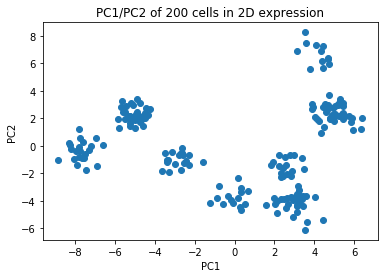

In [17]:
plt.scatter(Yq_1,Yq_2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1/PC2 of 200 cells in 2D expression')
plt.show()

In [18]:
def visualize_data_leina(data,assignments,Yq_1,Yq_2):

    # We can assign colors to up to Q=8 components
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
     'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender']
    col=[]
    for i in assignments: 
        col.append(colormap[i]) 
    
    plt.scatter(Yq_1,Yq_2,c=col)

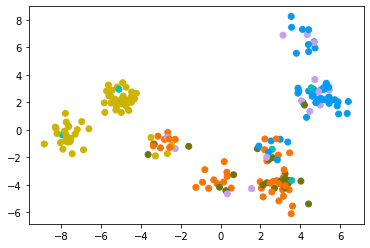

In [19]:
visualize_data_leina(data,assignments,Yq_1,Yq_2)

something went wrong with colors attribution(will be fixed later)

Was Watson right to expect 8 clusters? 
By eye we can detcect 8 groups of cell that cluster together so yes he was right 
Now we want to check if the 2 first Principal alone are sufficent to explain most of the variance for that lets, 
Plot the eigenvalues for each component, and justify why you’re pretty
sure it would be hard to find any other clusters in the data set. The eigenvalues from a simulated negative
control data set, where there were no cell types and no correlations between any of the genes, should factor into
your answer.


You're looking at a projection into 2D PCA space and it shows you 8 clusters. What's the argument that there isn't some other (3rd or higher) dimension that's just as biologically significant, and your "clusters" are actually two or more clusters projected on top of each other in your 2D plot? That is, what says that the clusters you see in 2D PCA space are likely to be capturing the meaningful variation in the original data space?


In [20]:
#load negative control data 
negative_control_data=pd.read_table('w10-eigen.tbl',delim_whitespace=True,comment="#",names=['pc_number','eigenvalue'])
#negative_control_data

/Users/leinaessakalli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


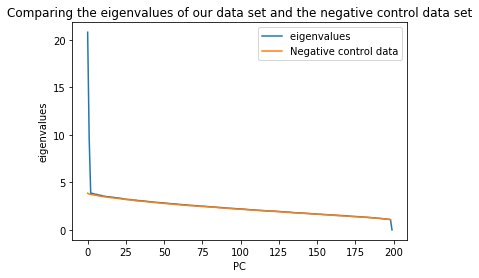

In [21]:
plt.plot(eigen_values,label = 'eigenvalues ')
plt.plot(negative_control_data['eigenvalue'],label = 'Negative control data')
plt.legend()
plt.ylabel('eigenvalues')
plt.xlabel('PC')
plt.title('Comparing the eigenvalues of our data set and the negative control data set')
plt.show()


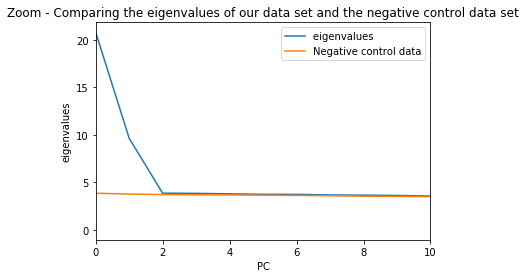

In [22]:
plt.plot(eigen_values,label = 'eigenvalues ')
plt.plot(negative_control_data['eigenvalue'],label = 'Negative control data')
plt.xlim([0,10])
plt.legend()
plt.ylabel('eigenvalues')
plt.xlabel('PC')
plt.title('Zoom - Comparing the eigenvalues of our data set and the negative control data set')
plt.show()

After PC2 the eigen value of negative control data and our data overlap(its just noise )- 
this confirms that we only need 2 PC (and we are not missing important clusters)

so only 2 PC can explain most the variance because after that its the same as noise


how many genes appear to influence cell type identity?
we want to identify the genes that explain a lot of varaince of the 2 first principals compoenemnts - 
the rows that have a value for W1(first col of W ) & for W2(2nd col of W) that are both higher than a threshold (that i setted arbitratry to 0.05)

Based on the eigenvector loadings, how many genes appear to influence cell type identity?
lets first identify the threshold of where we can say that the is an influence 

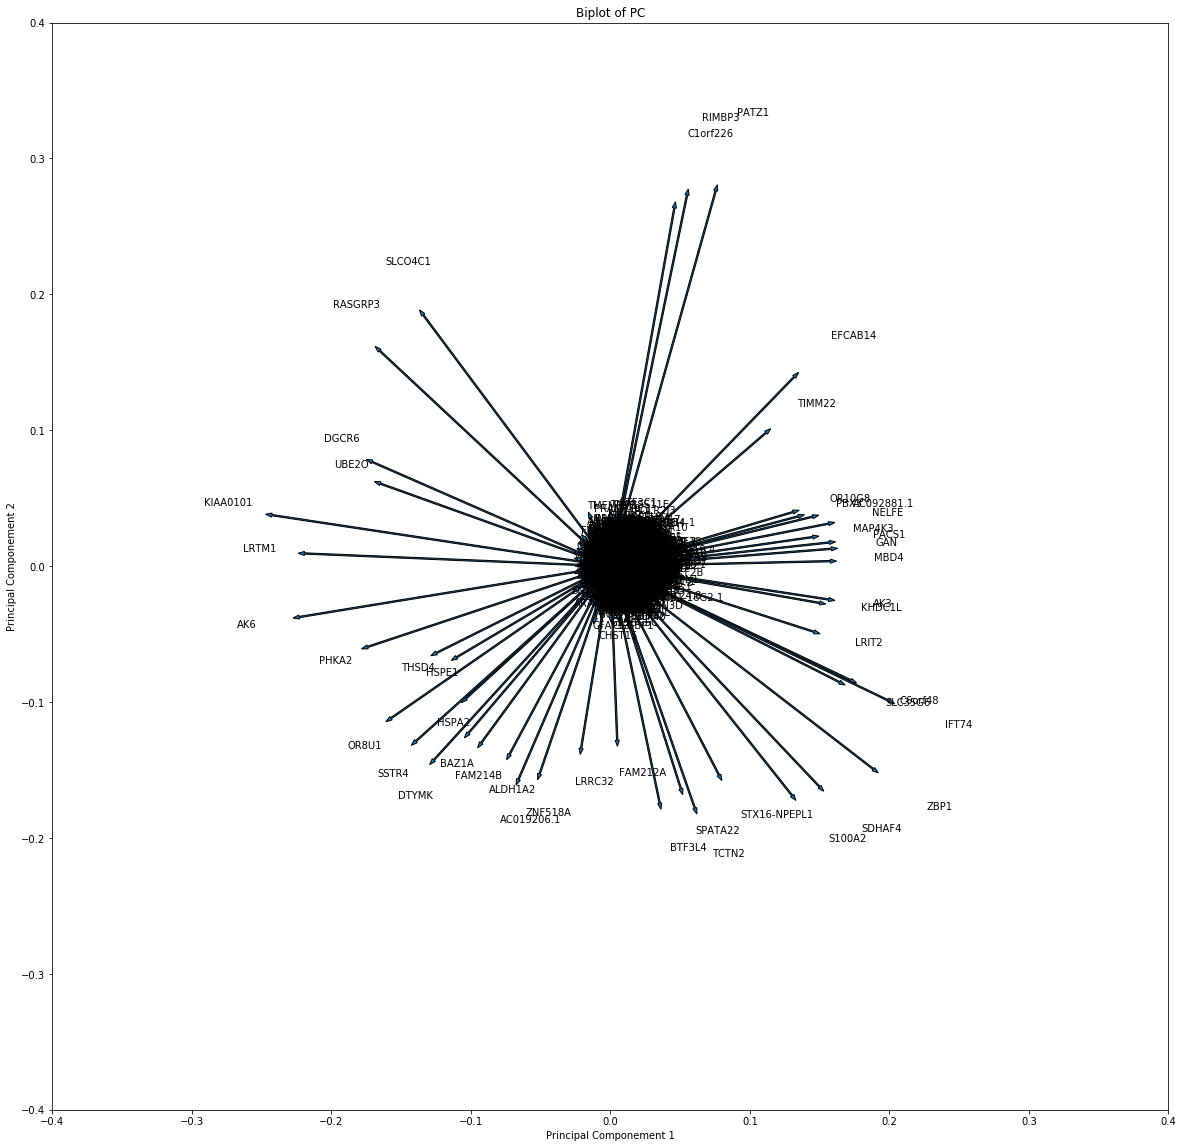

In [23]:
plt.figure(figsize=(20,20))

for i in range(G):
    plt.arrow(0, 0, W_matrix[i,0], W_matrix[i,1],alpha = 1)
    plt.text(W_matrix[i,0]* 1.2, W_matrix[i,1] * 1.2, g_names[i])


plt.title('Biplot of PC')
plt.xlabel('Principal Componement 1')
plt.ylabel('Principal Componement 2')
plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)
plt.show()

We only want to consider the genes that are NOT in the middle - 
Using the biplot, by eye we can deduce that the threshold is 0.1 (in absolute value)
what is the list of index of these genes?

In [24]:
boolean_array=(np.abs(W_1)>0.1)+(np.abs(W_2)>0.1)
number_genes = sum(boolean_array)
index_influent_genes=np.where(boolean_array)[0] #this is when the boolean array takes the value of true(and therefore both ot the conditions are fullfiled)
print(number_genes,'genes appear to influence cell type identity')
print('their index are ',index_influent_genes)


47 genes appear to influence cell type identity
their index are  [  84   88  136  152  235  238  255  317  341  377  387  420  538  548
  631  632  659  662  805  971  979  988 1022 1093 1118 1134 1171 1220
 1232 1317 1354 1409 1427 1485 1492 1498 1594 1602 1608 1616 1704 1766
 1786 1787 1933 1934 1952]


# part 3
Plot the data in 2D principal component space, and color each point according to the cluster identities from part
1. You should find the K-means is missing the mark.
Offer an explanation of what might be going wrong, and find a way to cluster so that each cell appears properly
assigned in PC space.


I used my code from PSET 5

We now know that only 2 PC are useful so lets use my code(that could handle only 2 dimensions) 

In [25]:
def assign_empty(c, clusters, distances):
   # find index of point furthest from its assigned center
    max_idx = np.argmax(distances)
   # set distances at that index to 0
    distances[max_idx] = 0
   # set clusters at that index to empty cluster
    clusters[max_idx] = c
    return clusters, distances

In [26]:
coords=Yq
def assignment(coords, centers):
    total_square_distance =0
  # Assign each point to the closest center
    clusters =  [np.argmin([math.sqrt((point[0]-i[0])**2+(point[1]-i[1])**2) for i in centers]) for point in coords]
   # record the distance between a point and its closet center
    distances = [np.min([math.sqrt((point[0]-i[0])**2+(point[1]-i[1])**2) for i in centers]) for point in coords]
   # Count how many points in each cluster
    c = collections.Counter(clusters)
   # Look for empty clusters
    for x in set(range(len(centers))).difference(set(c.keys())):
        clusters, distances =  assign_empty(x, clusters, distances)
   # calculate the total squared distance
    for i in distances:
        total_square_distance = total_square_distance+i**2
    return (clusters,total_square_distance)

In [27]:
def update(coords, clusters, num_clust):
    coords = np.asarray(coords)
   # Find indices of each point assigned to each cluster
    clusters_indice = ([np.where(np.asarray(clusters) == x) for x in range(num_clust)])
   # Average position of each point assigned to each cluster to get the updated centroids
    centers = [np.mean(coords[clusters_indice[x]],0) for x in range(len(clusters_indice))]
    return centers

In [28]:
def visualize_data_part3(data, mu, C):
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N
   # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard',
               'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']
    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.plot( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

In [29]:
n_runs = 20
# Initalize best clusters
min_distance = float('inf')
clusters_best = []
distance_reccords=[]
for i in range(n_runs):
   # print('run number',i+1) #keep track
    coords_x = [c[0] for c in coords]
    coords_y = [c[1] for c in coords]
    centers_x = np.random.choice(np.linspace(min(coords_x),max(coords_x),1000),8)
    centers_y = np.random.choice(np.linspace(min(coords_y),max(coords_y),1000),8)
    centers = [[centers_x[i], centers_y[i]] for i in range(0,8)]
   # Start with empty clusters
    clusters_old = []*len(coords)
    clusters = [0]* len(coords)
    while clusters != clusters_old:
       # Update clusters
       clusters_old = clusters
       # New Assignment
       clusters,total_sqdist = assignment(coords, centers)
       # New centers
       centers = update(coords, clusters, 8)
    distance_reccords.append(total_sqdist)
   # Save clusters and centers if it has minimal sum distance to date
    if total_sqdist < min_distance:
        min_distance = total_sqdist
        centers_best = centers
        clusters_best = clusters

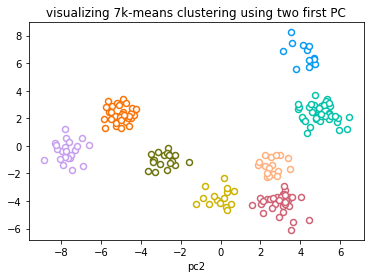

In [30]:
visualize_data_part3(np.array(coords), np.array(centers_best), clusters_best)
plt.title('visualizing 7k-means clustering using two first PC')
plt.xlabel('pc1')
plt.xlabel('pc2')
plt.show()

# part 4
Reconstruct the original data set using only the projected data and eigenvectors for the first 2 principal
components. Visualize the data using a heat map. Do the clusters now look more obvious? Why or why not?

In [31]:
#denoising 
Wq_T=Wq.transpose()
Sigma_q=diagonal_matrix[0:2,0:2] 
U_q=U[:, [0,1]]
 

In [32]:
X_centered_q=U_q@Sigma_q@Wq_T

In [33]:
#Sigma_q
X_Reconstruct=X_centered_q+np.mean(X_centered_q,axis=0) #'decenter the data'
X_Reconstruct

array([[ 1.47148490e-02, -2.74001467e-03, -5.11750826e-02, ...,
         9.99413688e-04, -6.13625407e-02,  1.20656884e-01],
       [-7.97170254e-03, -5.18660247e-03, -5.46468023e-02, ...,
         2.48527967e-03, -6.86476659e-02,  1.07348727e-01],
       [ 8.27276676e-02,  1.14686250e-02,  4.41093283e-02, ...,
        -6.57389782e-03,  6.54678888e-02, -1.74141938e-02],
       ...,
       [-5.96243703e-02, -1.14381161e-02, -7.09615199e-02, ...,
         6.17733138e-03, -9.56377761e-02,  9.46834313e-02],
       [-1.00418445e-01, -1.51740710e-02, -6.90127903e-02, ...,
         8.54816356e-03, -9.86049890e-02,  5.35774845e-02],
       [-2.23374906e-02,  4.48756126e-05,  2.68804497e-02, ...,
         3.49677437e-04,  3.03057957e-02, -7.66335336e-02]])

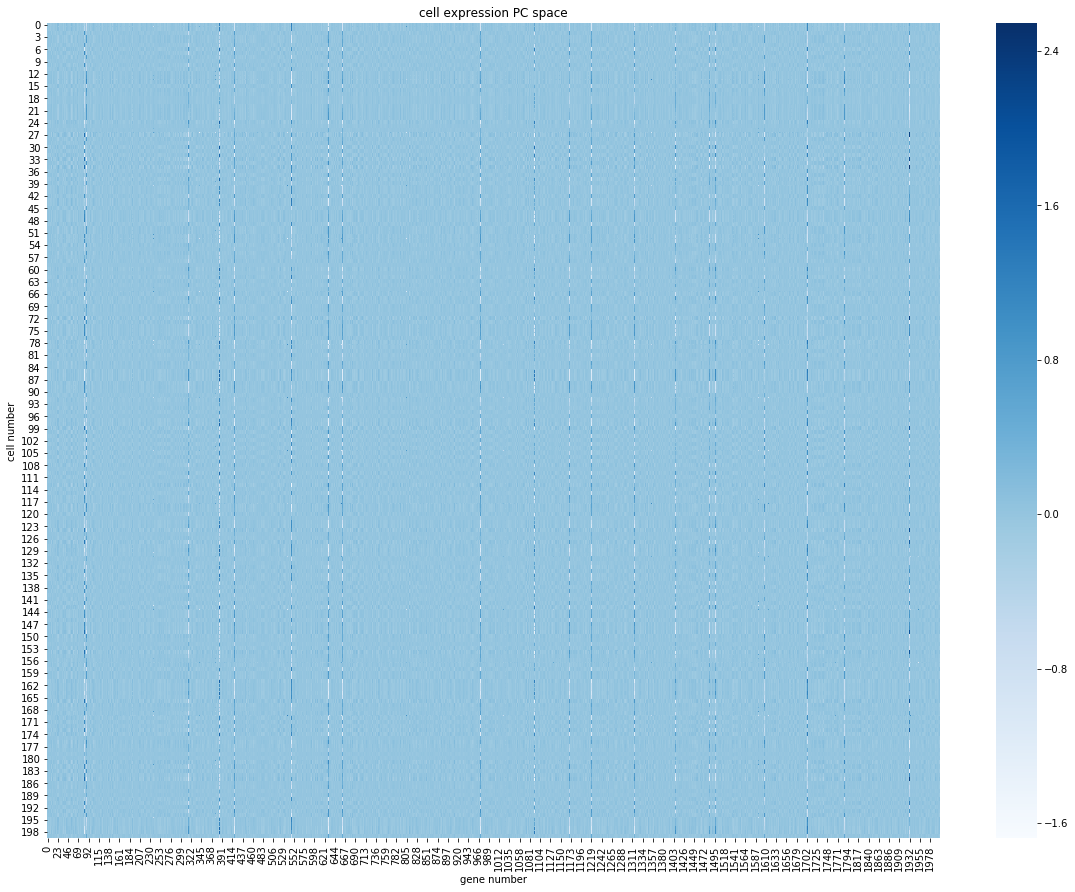

In [34]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_Reconstruct,cmap='Blues')
plt.title('cell expression PC space')
plt.xlabel("gene number")
plt.ylabel("cell number")
plt.show()

not very informative/lets select only gene that are influencal/reogranise the matrix by group of clusters

create a 2D matrix where each with 8 rows, each one correspond to one cluster and contain the index of the cell that are assigned to this cluster 

In [35]:
cells_index_per_cluster = ([np.where(np.asarray(clusters_best) == cluster_number) for cluster_number in range(0,Q)])

# from 2D to 1D - but this time its grouped by clusters(done using the 2d matrix cells_index_per_cluster created above  )
assignement_list = []
for cluster_number in range(Q):
    for i in range(len(cells_index_per_cluster[cluster_number][0])):
        assignement_list.append(cells_index_per_cluster[cluster_number][0][i])
assignement_list 

  
Xq_reconstruct_ordered = (np.array([X_Reconstruct[cluster_id].tolist() for cluster_id in assignement_list]))# Now lets reorder or X matrix in the order of assignement_list   
Xq_reconstructed_sorted_influencal=Xq_reconstruct_ordered[:,index_influent_genes] #select only by ID the influent genes 

print(Xq_reconstructed_sorted_influencal.shape) #check ok 


(200, 47)


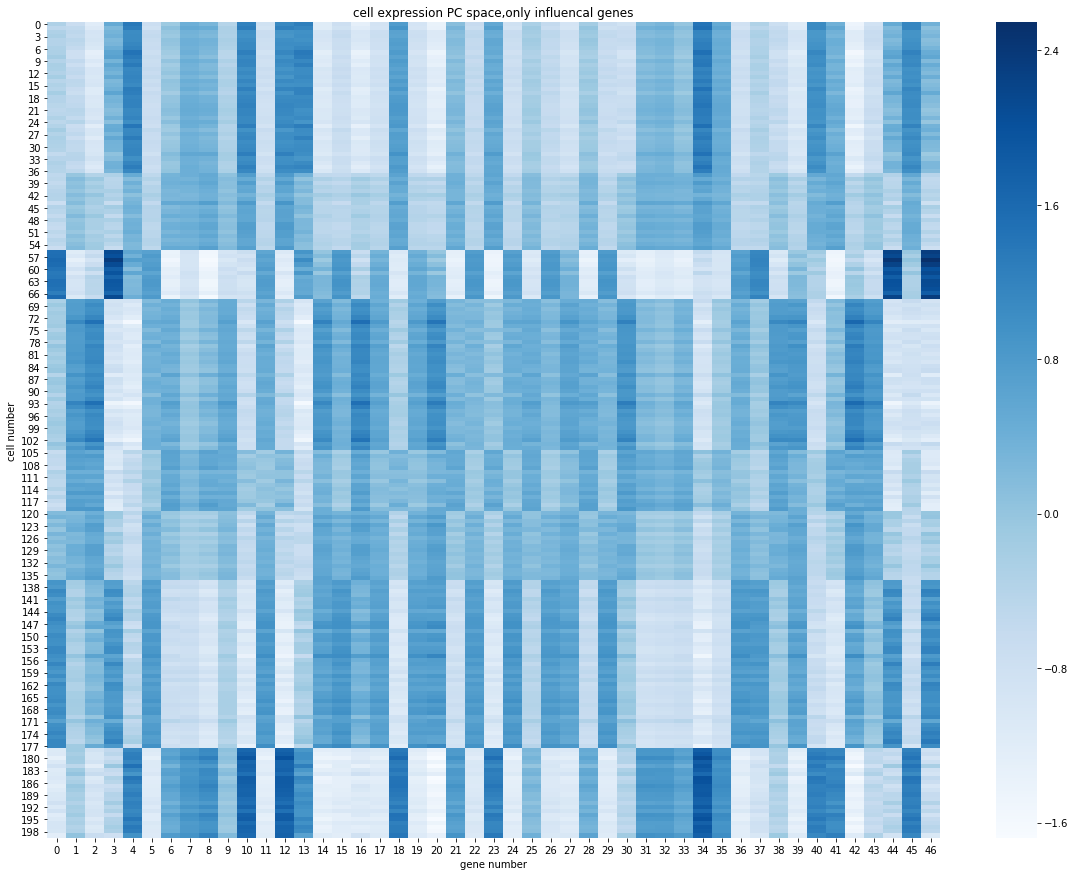

In [36]:
plt.subplots(figsize=(20,15))
sns.heatmap(Xq_reconstructed_sorted_influencal,cmap='Blues')
plt.title('cell expression PC space,only influencal genes')
plt.xlabel("gene number")
plt.ylabel("cell number")
plt.show()

we can see that there is clearly 8 different group of cells that are clustering together 